# Testing.

In [ ]:
import numpy as np
import time
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
from lossycomp.compress import compress
from lossycomp.decompress import decompress
from lossycomp.plots import single_plot
from lossycomp.encodings import encode_lat, encode_lon

In [2]:
data_or = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc', combine='by_coords')
data_or = data_or.sel(time=slice('1980-04-12T00:00:00','1980-4-13T23:00:00'),level = slice(978,1000), longitude=slice(-180,180), latitude=slice(90,-90))
data_or = data_or.transpose('time', 'latitude', 'longitude', 'level')

In [3]:
extra = False
soil = False
if extra:
    # In case we use the extra information:
    lat = data_or['t'].coords['latitude'].values
    lon = data_or['t'].coords['longitude'].values

    lat_st = np.stack([encode_lat(x) for x in lat])
    lon_st = np.stack([encode_lon(x) for x in lon])

    lat1, lat2 = np.hsplit(lat_st, 2)
    lon1, lon2 = np.hsplit(lon_st, 2)

    xx, yy = np.meshgrid(lon1, lat1)
    xx2, yy2 = np.meshgrid(lon2, lat2)

    coords_lat = np.concatenate([[xx]] * len(data_or.time), axis=0)
    coords_lon = np.concatenate([[yy]] * len(data_or.time), axis=0)
    coords_lat1 = np.concatenate([[xx2]] * len(data_or.time), axis=0)
    coords_lon1 = np.concatenate([[yy2]] * len(data_or.time), axis=0)

    coords_lat = np.expand_dims(coords_lat, axis=3)
    coords_lon = np.expand_dims(coords_lon, axis=3)

    coords_lat1 = np.expand_dims(coords_lat1, axis=3)
    coords_lon1 = np.expand_dims(coords_lon1, axis=3)

    temp = data_or['t'].values
    data_or =  np.concatenate((temp, coords_lat, coords_lon, coords_lat1, coords_lon1 ),axis = 3)

    data_or.shape
    # 402.84 MB
if soil:
    data_soil = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1980/*/ERA5.sl.land_sea_mask.nc', combine='by_coords')
    data_soil = data_soil.sel(time=slice('1980-04-12T00:00:00','1980-4-13T23:00:00'),longitude=slice(-180,180), latitude=slice(90,-90))
    data_soil = data_soil.transpose('time', 'latitude', 'longitude')
    data_soil = data_soil['lsm']
    data_soil = np.expand_dims(data_soil.values, axis=3)
    data_or =  np.concatenate((data_or['t'].values, data_soil ),axis = 3)

if not (soil or extra):
    data_or = data_or['t']
    data_or = data_or.values


In [14]:
threshold = 0.01
compressed_data = compress(data_or, threshold, extra_channels = False, verbose = False, method='mask', mode = 'None', convs = 4, hyp = 15)

In [15]:
error = compressed_data[1]
mask = compressed_data[2]
decompressed = compressed_data[3]
comp_data = compressed_data[4]
decom_error = compressed_data[5]
quan = compressed_data[6]

In [16]:
decompressed_data = decompress(compressed_data[0], comp_data, extra_channels = False, verbose = False, method='mask', mode = 'None', convs = 4, hyp = 15)

In [17]:
mask_d = decompressed_data[1]
error_d = decompressed_data[2]
decom_error_d = decompressed_data[4]
comp_d = decompressed_data[5]
quan_d = decompressed_data[6]
decompressed_d = decompressed_data[7]

In [18]:
np.all(mask == mask_d )

True

In [19]:
np.all(comp_data == comp_d )

True

In [20]:
np.all(error_d == error )

True

In [21]:
np.all(quan == quan_d)

False

In [22]:
quan_d

array([2.58, 1.16, 0.14, ..., 1.68, 4.58, 6.42])

In [23]:
np.all(decompressed_d == decompressed)

True

In [24]:
error_de = data_or - (decompressed_data[0])
print('Min:', np.min(error_de))
print('Max:', np.max(error_de))

Min: -0.010009766
Max: 0.010009766


In [10]:
def psnr(y,x):
    vrange = np.max(y) - np.min(y)
    psnr = 20 * np.log10(vrange - (10 * np.log10(np.mean((y-x)*(y-x)))))
    return psnr


psnr1 = psnr(data_or[:,:,:,0], decompressed_data[:,:,:,0])
print('PSNR', psnr1)

TypeError: tuple indices must be integers or slices, not tuple

(1, 48, 721, 1440, 1)


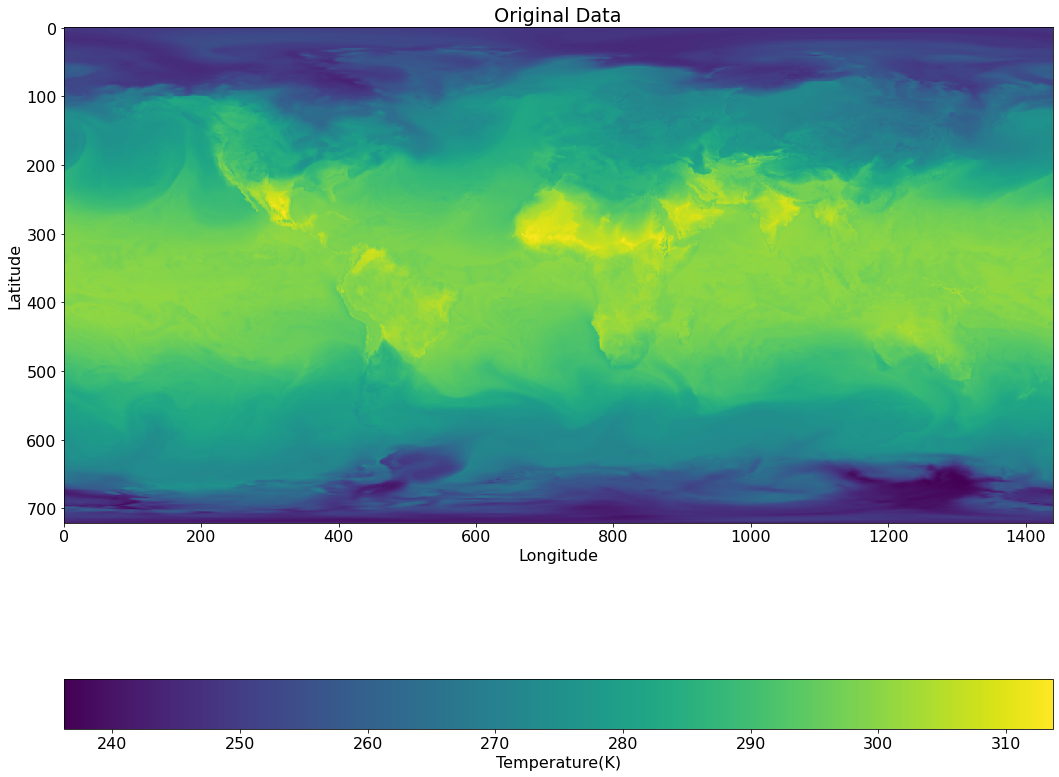

In [53]:
data_r = np.expand_dims(data_or[:,:,:,0], axis=0)
#data_r = np.expand_dims(data_or, axis=0)
data_r = np.expand_dims(data_r, axis=4)
print(data_r.shape)
plt.rcParams.update({'font.size': 16})
single_plot(data_r, 0, "Original Data", "Temperature(K)", data_r[0,0].min(), data_r[0,0].max())

(1, 48, 721, 1440, 1)


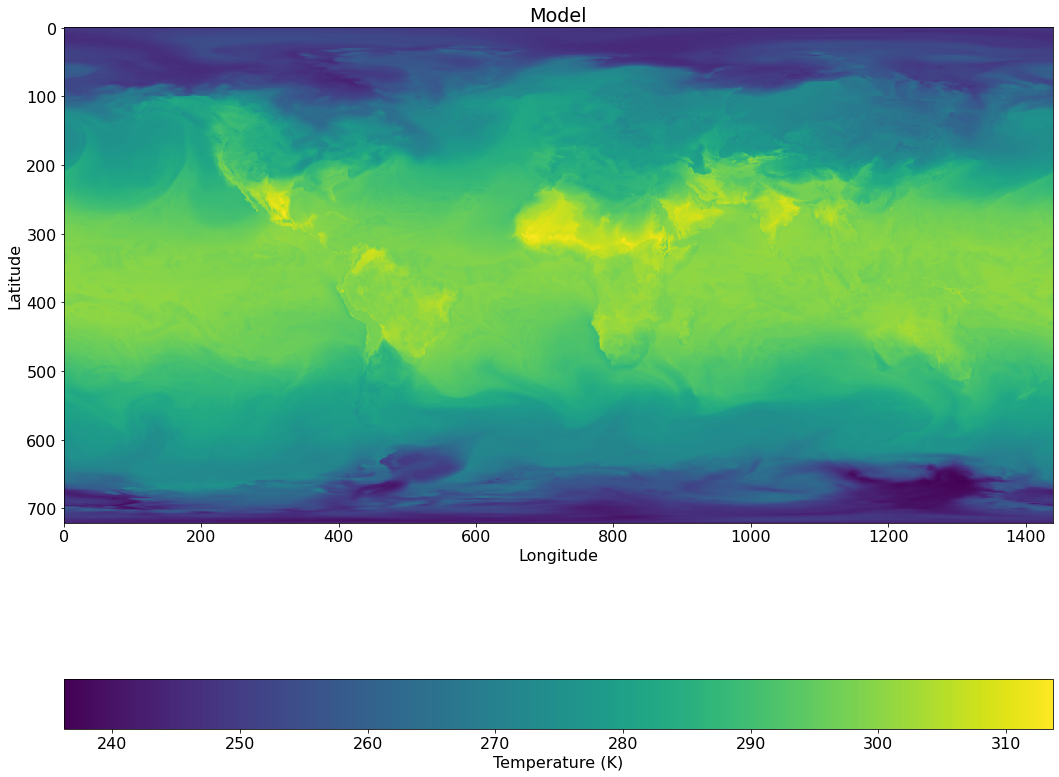

In [54]:
decom = np.expand_dims(decompressed_data, axis=0)
print(decom.shape)
single_plot(decom, 0, "Model", "Temperature (K)", data_r[0,0].min(), data_r[0,0].max())

In [55]:
decom1 = np.expand_dims(decom_model, axis=0)
print(decom1.shape)
single_plot(decom1,0, "Decompressed Data Data", "Temperature (K)", decom_model.min(), decom_model.max())

NameError: name 'decom_model' is not defined

In [ ]:
diff = (data_r-decom1)
diff = np.mean(diff, axis = 1)
diff = np.expand_dims(diff, axis=0)
print(diff.shape)
# define the colormap
cmap = plt.get_cmap('PuOr')

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

single_plot(diff,0,  "Input Data - Autoencoder Output Error", "Error (K)", diff.min(), 9.7, cmap=cmap)

In [ ]:
diff = (data_r-decom)
diff = np.mean(diff, axis = 1)
diff = np.expand_dims(diff, axis=0)
print(diff.shape)
# define the colormap
cmap = plt.get_cmap('PuOr')

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

single_plot(diff,0,  "Input Data - Decompressor Output Error", "Error (K)", diff.min(), diff.max(), cmap=cmap)


Data Original
Mean: 279.58743
Standard Dev.: 18.20704
Max Val: 317.70856
Min Val: 233.46681

Decompressed
Mean: 279.58417
Standard Dev.: 18.157076
Max Val: 317.72534
Min Val: 233.51312

Error
Mean: 0.0036678745
Standard Dev.: 0.0720197
Max error: 0.4975891
Min error: -0.6236725



Text(0, 0.5, 'Count')

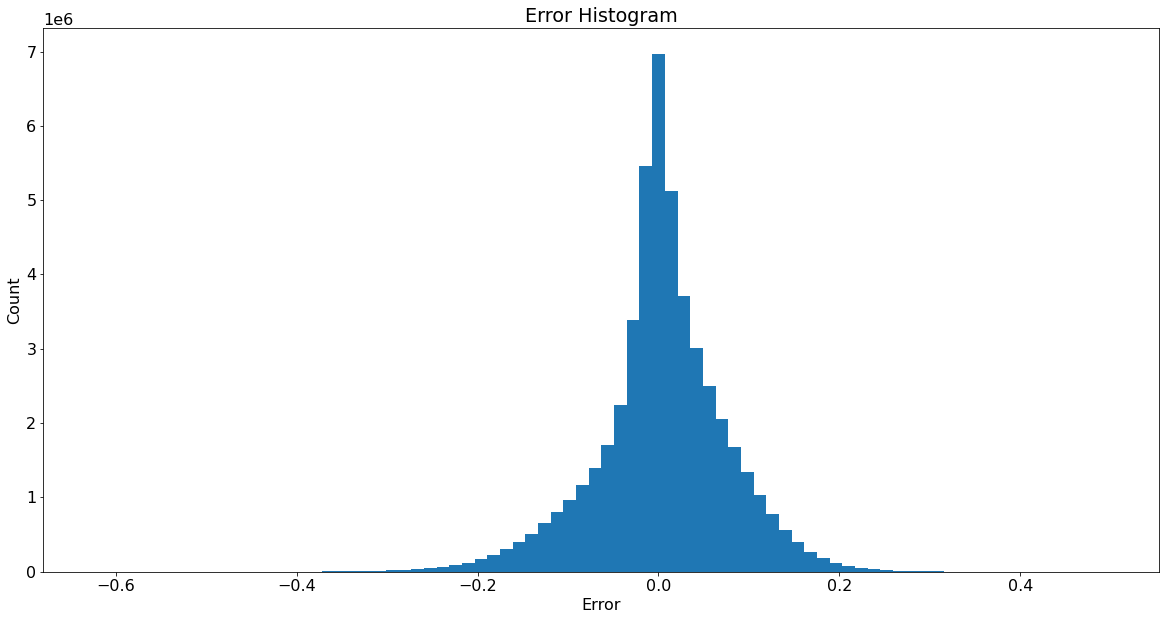

In [56]:
original = data_r
diff = (data_r-decom)

print("")
print("Data Original")
print("=======")
print("Mean:", original.mean())
print("Standard Dev.:", original.std())
print("Max Val:", original.max())
print("Min Val:", original.min())
print("")
print("Decompressed")
print("=======")
print("Mean:", decom.mean())
print("Standard Dev.:", decom.std())
print("Max Val:", decom.max())
print("Min Val:", decom.min())
print("")
print("Error")
print("=======")
print("Mean:", diff.mean())
print("Standard Dev.:", diff.std())
print("Max error:", diff.max())
print("Min error:", diff.min())
print("")


diff2 = data_r-decom
plt.figure(figsize=(20,10))
plt.hist(diff2.flatten(),80)
plt.title('Error Histogram')
plt.xlabel('Error')
plt.ylabel('Count')

In [13]:
import pickle
import numpy as np
with open('../lossycomp/cf_zfp_vs_5_vs_sz_history.pkl', 'rb') as f:
    data = pickle.load(f)

In [9]:
data.keys()
data['sz'].keys()

dict_keys(['cf_0.001', 'cf_0.01', 'cf_0.1', 'cf_0.3', 'cf_0.5', 'cf_0.7', 'cf_1', 'cf_3', 'cf_5'])

In [11]:
cf_1 = []
cf_5 = []
cf_sz = []

cf_1_std = []
cf_5_std = []
cf_sz_std = []

latent_1= []
latent_5=[]
latent_sz=[]

latent_1_std= []
latent_5_std=[]
latent_sz_std=[]

error_1=[]
error_5=[]
error_sz=[]

error_1_std=[]
error_5_std=[]
error_sz_std=[]

vals =  [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1,  3, 5]


for i in [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 3, 5]:
    cf_1.append(np.mean(data['zfp']['cf_' + str(i)]))
    cf_5.append(np.mean(data['channel_5']['cf_' + str(i)]))
    cf_sz.append(np.mean(data['sz']['cf_' + str(i)]))
    
    cf_1_std.append(np.std(data['zfp']['cf_' + str(i)]))
    cf_5_std.append(np.std(data['channel_5']['cf_' + str(i)]))
    cf_sz_std.append(np.std(data['sz']['cf_' + str(i)]))
        
    latent_1.append(np.mean(data['zfp']['latent_' + str(i)]))
    latent_5.append(np.mean(data['channel_5']['latent_' + str(i)]))
    latent_sz.append(np.mean(data['sz']['latent_' + str(i)]))
    
    latent_1_std.append(np.std(data['zfp']['latent_' + str(i)]))
    latent_5_std.append(np.std(data['channel_5']['latent_' + str(i)]))
    latent_sz_std.append(np.std(data['sz']['latent_' + str(i)]))
    
    error_1.append(np.mean(data['zfp']['error_' + str(i)]))
    error_5.append(np.mean(data['channel_5']['error_' + str(i)]))
    error_sz.append(np.mean(data['sz']['error_' + str(i)]))
    
    error_1_std.append(np.std(data['zfp']['error_' + str(i)]))
    error_5_std.append(np.std(data['channel_5']['error_' + str(i)]))
    error_sz_std.append(np.std(data['sz']['error_' + str(i)]))

Text(0, 0.5, 'Compression Factor')

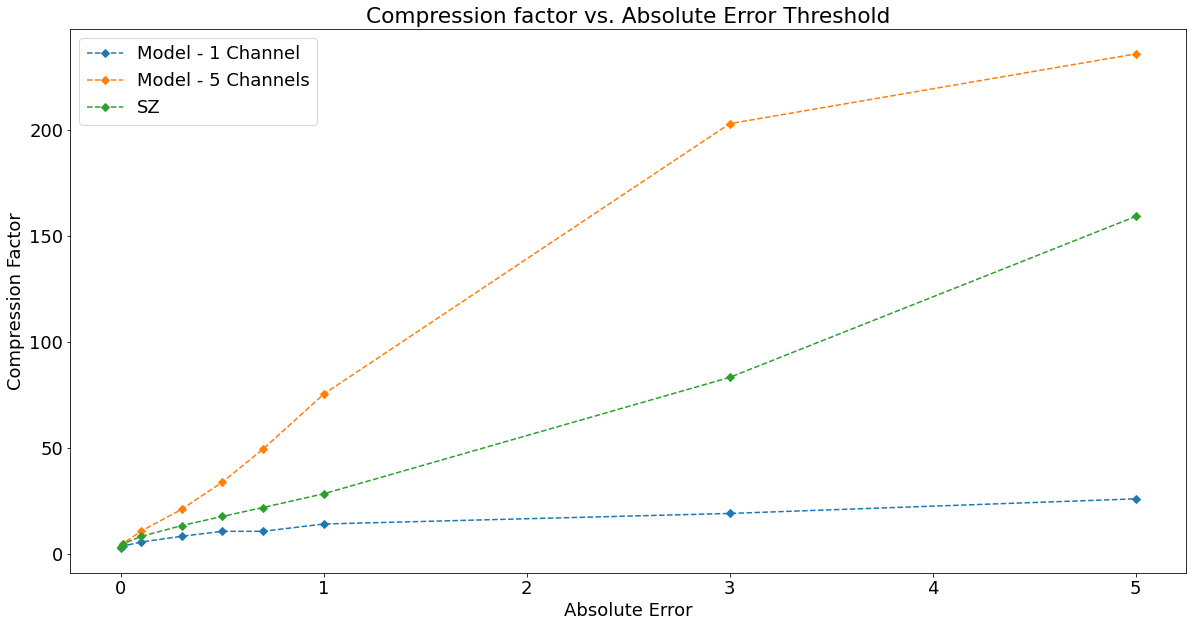

In [12]:
import matplotlib.pyplot as plt
epochs = range(len(cf_1))

plt.figure(figsize=(20,10))
plt.plot(vals, cf_1, '--D', label = "Model - 1 Channel")
plt.plot(vals, cf_5, '--D', label = "Model - 5 Channels")
plt.plot(vals, cf_sz, '--D',  label = "SZ")

plt.legend()
plt.title('Compression factor vs. Absolute Error Threshold')
plt.xlabel('Absolute Error')
plt.ylabel('Compression Factor')

/home/kit/scc/nq1231/.site-packages/lib/jupyter_ml/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


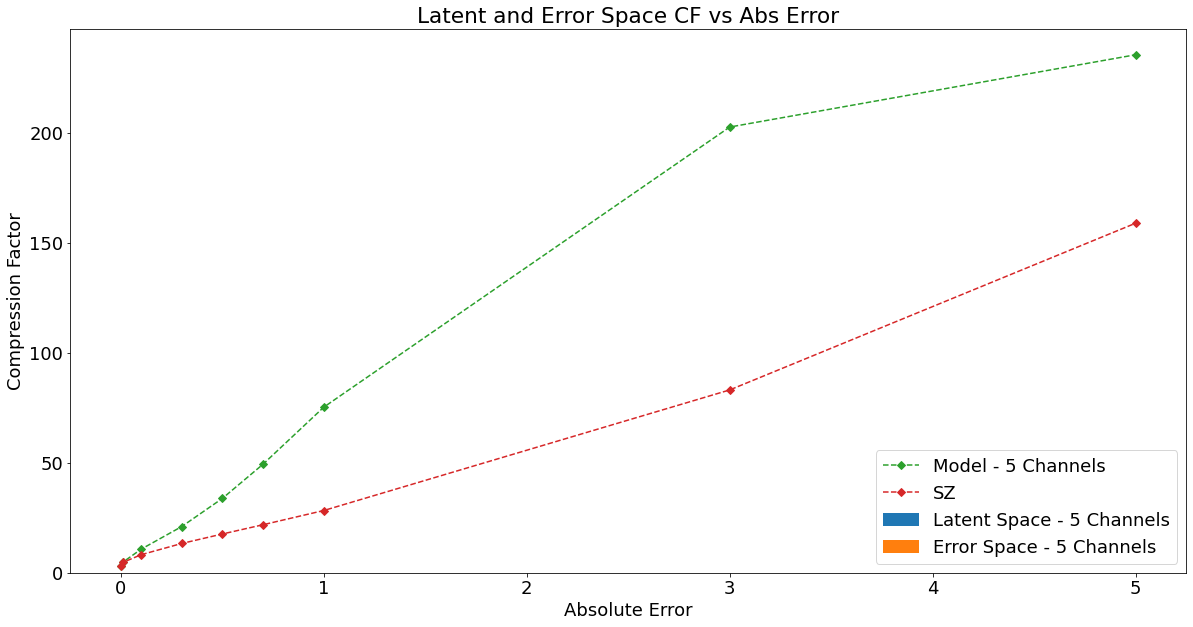

In [13]:

#plt.figure(figsize=(20,10))
width = 0.05# the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(20,10))

vals_2 = np.array(vals) + 0.05

latent_1_x = np.array(latent_1) * np.array(cf_1)
latent_5_x = np.array(latent_5) * np.array(cf_5)

error_1_x = np.array(error_1) * np.array(cf_1)
error_5_x = np.array(error_5) * np.array(cf_5)

latent_1_std_x = np.array(latent_1_std) * np.array(cf_1)
latent_5_std_x = np.array(latent_5_std) * np.array(cf_5)

error_1_std_x = np.array(error_1_std) * np.array(cf_1)
error_5_std_x = np.array(error_5_std) * np.array(cf_5)

#ax.bar(vals,latent_1_x, width, yerr=latent_1_std_x, label='Latent Space - 1 Channel')
#ax.bar(vals, error_1_x, width, yerr= error_1_std_x, bottom=latent_1_x,
#       label='Error Space - 1 Channel')

ax.bar(vals_2,latent_5_x, width, yerr=latent_5_std_x, label='Latent Space - 5 Channels')
ax.bar(vals_2, error_5_x, width, yerr= error_5_std_x, bottom=latent_5_x,
       label='Error Space - 5 Channels')

#ax.plot(vals, cf_1, '--D', label = "Model - 1 Channel")
ax.plot(vals, cf_5, '--D', label = "Model - 5 Channels")
ax.plot(vals, cf_sz, '--D',  label = "SZ")

ax.set_ylabel('Compression Factor')
ax.set_xlabel('Absolute Error')
ax.set_title('Latent and Error Space CF vs Abs Error')
ax.legend()

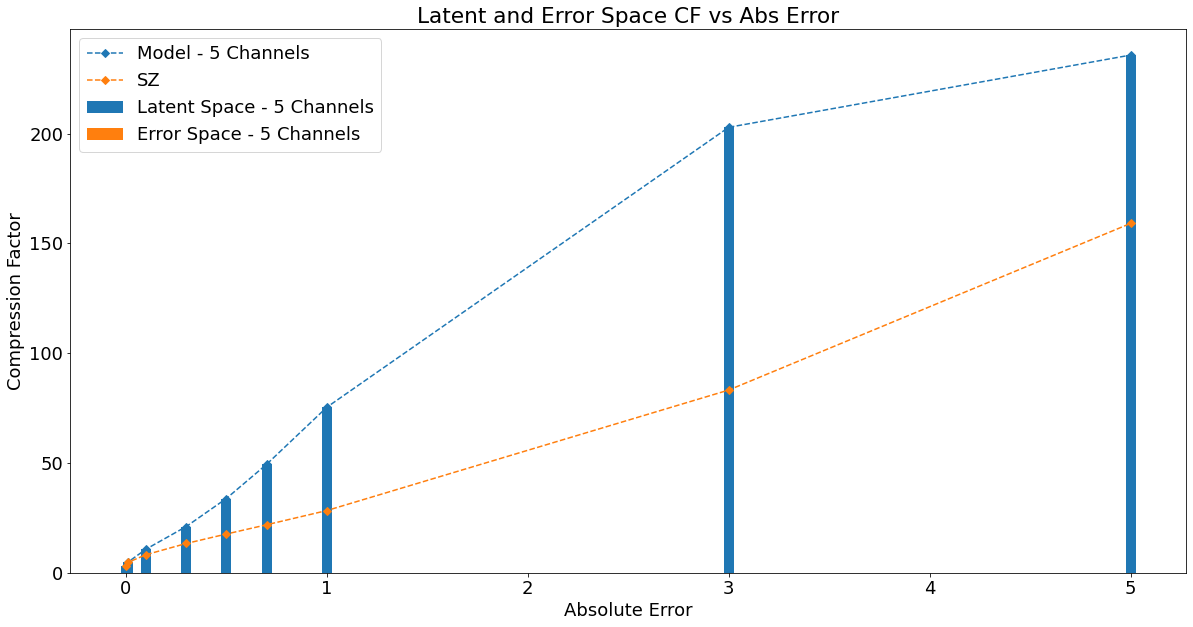

In [14]:

#plt.figure(figsize=(20,10))
width = 0.05# the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(20,10))

vals_2 = np.array(vals) + 0.05

latent_1_x = np.array(latent_1) * np.array(cf_1)
latent_5_x = np.array(latent_5) * np.array(cf_5)

error_1_x = np.array(error_1) * np.array(cf_1)
error_5_x = np.array(error_5) * np.array(cf_5)

latent_1_std_x = np.array(latent_1_std) * np.array(cf_1)
latent_5_std_x = np.array(latent_5_std) * np.array(cf_5)

error_1_std_x = np.array(error_1_std) * np.array(cf_1)
error_5_std_x = np.array(error_5_std) * np.array(cf_5)

#ax.bar(vals,latent_1_x, width, yerr=latent_1_std_x, label='Latent Space - 1 Channel')
#ax.bar(vals, error_1_x, width, yerr= error_1_std_x, bottom=latent_1_x,
#       label='Error Space - 1 Channel')

#ax.bar(vals_2,latent_5_x, width, yerr=latent_5_std_x, label='Latent Space - 5 Channels')
#ax.bar(vals_2, error_5_x, width, yerr= error_5_std_x, bottom=latent_5_x,
#       label='Error Space - 5 Channels')

#ax.plot(vals, cf_1, '--D', label = "Model - 1 Channel")
ax.plot(vals, cf_5, '--D', label = "Model - 5 Channels")
ax.plot(vals, cf_sz, '--D',  label = "SZ")

ax.bar(vals, cf_5, width, yerr=latent_5_std_x, label='Latent Space - 5 Channels')
ax.bar(vals, cf_sz, width, yerr= error_5_std_x, bottom=latent_5_x,
       label='Error Space - 5 Channels')



ax.set_ylabel('Compression Factor')
ax.set_xlabel('Absolute Error')
ax.set_title('Latent and Error Space CF vs Abs Error')
ax.legend()

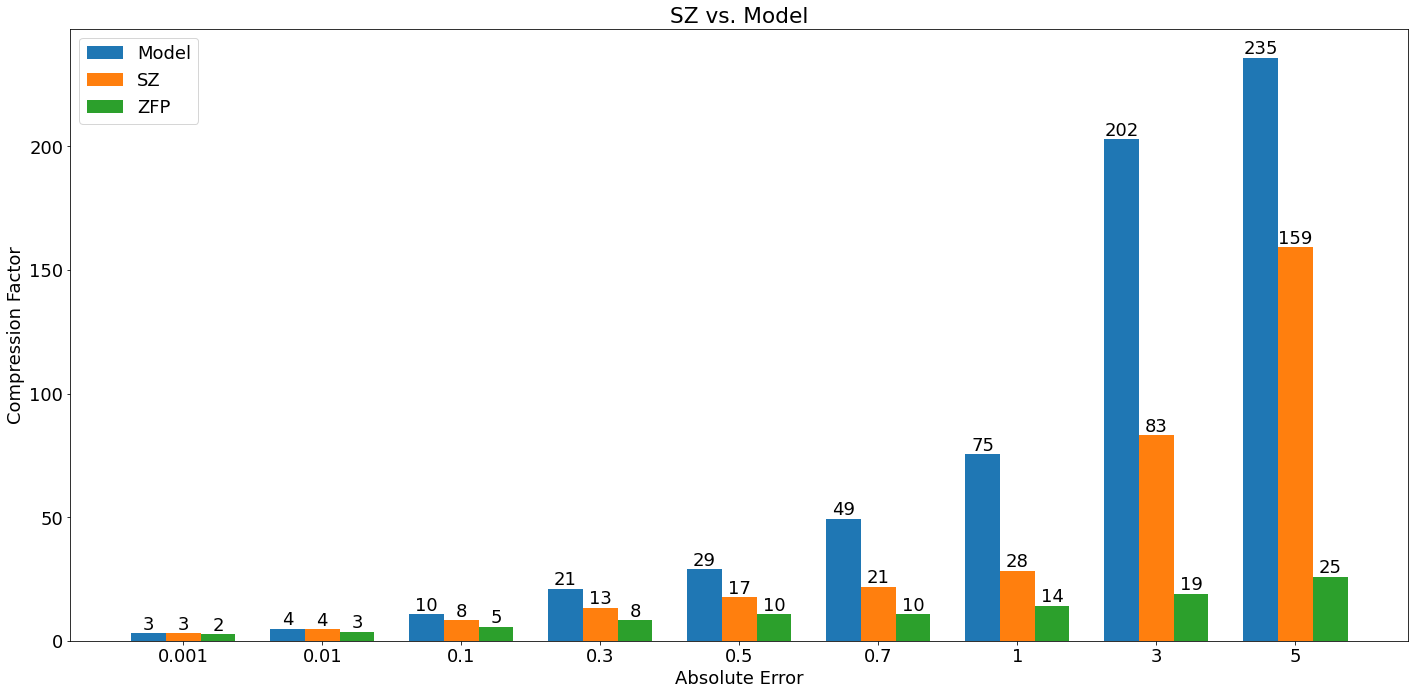

<Figure size 1440x720 with 0 Axes>

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 18})
labels = ['0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1', '3', '5']
cf_5[4]=29
men_means = cf_5
women_means =cf_sz
women_means_1 =cf_1

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = (20,10))
rects1 = ax.bar(x - width, men_means, width, label='Model')
rects2 = ax.bar(x , women_means, width, label='SZ')
rects3 = ax.bar(x + width, women_means_1, width, label='ZFP')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Compression Factor')
ax.set_xlabel('Absolute Error')
ax.set_title('SZ vs. Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.00*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.figure(figsize=(20,10))
plt.show()

In [14]:
vals

[0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 3, 5]

In [17]:
cf_sz

[3.1324225117394304,
 4.725736960798262,
 8.239808880514522,
 13.349114160332292,
 17.659935454882376,
 21.867436189191366,
 28.354627739115028,
 83.238168992133,
 159.12871713293728]

In [18]:
cf_5

[3.089510044457301,
 4.8374298338995185,
 10.751983396612875,
 21.050319914681236,
 29,
 49.376163425361135,
 75.3991490401777,
 202.9042005882004,
 235.80728975523692]

In [19]:
cf_1

[2.731679345727254,
 3.6728615857497067,
 5.596247844767189,
 8.314779502363336,
 10.648533944291238,
 10.648533944291238,
 14.086528676561173,
 19.06838536586952,
 25.95705536191974]

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
with open('../results/FINAL/CF_model_sz_zfp_1.pkl', 'rb') as f:
    data = pickle.load(f)

    
    
plt.rcParams.update({'font.size': 18})

labels = ['0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1']



men_means = cf_5
women_means =cf_sz
women_means_1 =cf_1

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = (20,10))
rects1 = ax.bar(x - width, men_means, width, label='Model')
rects2 = ax.bar(x , women_means, width, label='SZ')
rects3 = ax.bar(x + width, women_means_1, width, label='ZFP')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Compression Factor')
ax.set_xlabel('Absolute Error')
ax.set_title('SZ vs. Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.00*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.figure(figsize=(20,10))
plt.show()



In [4]:
import numpy as np
a = np.array([1,2,3,4,5])
a[2:5]

array([3, 4, 5])

In [15]:
import pickle
import numpy as np
with open('../results/FINAL/OPTIM/1/model-history.pkl', 'rb') as f:
    data = pickle.load(f)

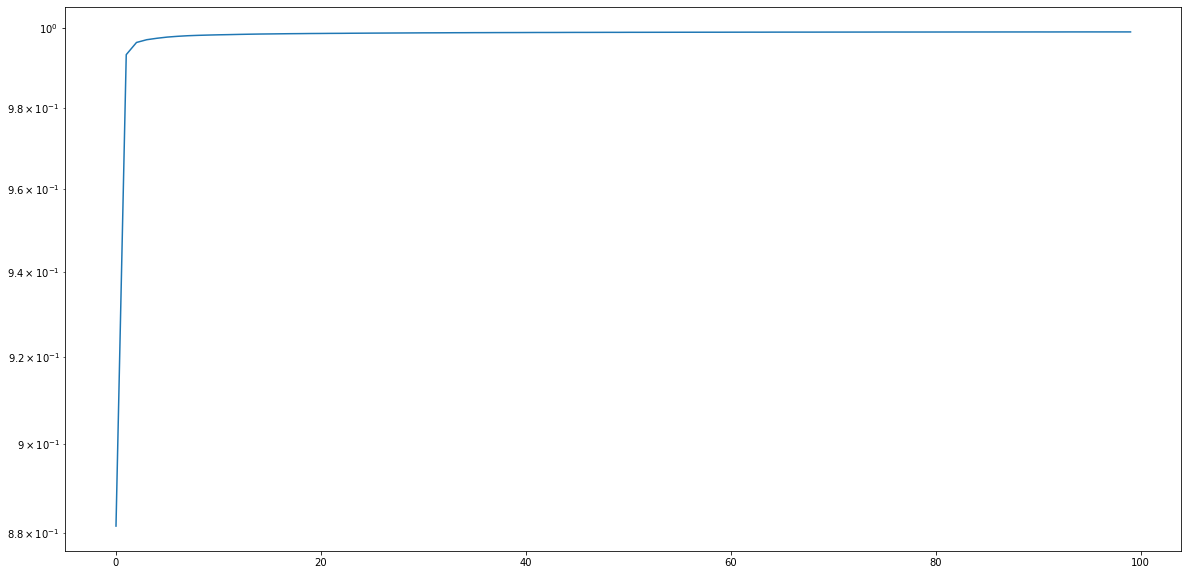

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle


x = range(len(data['model']['psnr']))
plt.figure(figsize=(20,10))
plt.plot(x, data['model']['correlation_5'])
plt.yscale("log")

plt.show()


In [22]:
data

{'parameters': {'num_convs': 4,
  'num_filters': 19,
  'kernel_size': 4,
  'lr': 2.1197407727820033e-05,
  'res_blocks': 0,
  'l2': 3.58380698062369e-05,
  'extra': False,
  'gaussian': False},
 'model': {'loss': [2.3026227951049805,
   0.09371580183506012,
   0.051665663719177246,
   0.04264220595359802,
   0.037684276700019836,
   0.03366953879594803,
   0.03092212975025177,
   0.028920436277985573,
   0.027587609365582466,
   0.026540806517004967,
   0.02561863698065281,
   0.02486504800617695,
   0.024091865867376328,
   0.023374296724796295,
   0.02277238853275776,
   0.02231239713728428,
   0.021891234442591667,
   0.0214534904807806,
   0.02114669419825077,
   0.020739257335662842,
   0.020464804023504257,
   0.020218413323163986,
   0.020001882687211037,
   0.019675424322485924,
   0.01946532167494297,
   0.01918690837919712,
   0.019006218761205673,
   0.01881503500044346,
   0.018596915528178215,
   0.018411904573440552,
   0.018225733190774918,
   0.018074881285429,
   0.017